In [1]:
%matplotlib inline
import random
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt
import time
import numpy as np
import math

dataset_root_dir = './polyU/train/'
dataset_root_dir1 = './polyU/train/'   #噪声
tdataset_root_dir = './polyU/test/'
tdataset_root_dir1 = './polyU/test/'   #噪声
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)

cuda:0


In [2]:
# 返回加噪声和原图片
class NoisyBSDSDataset(td.Dataset):

    def __init__(self, root_dir,root_dir1, mode='real',mode1='mean', image_size=(180, 180)):
        super(NoisyBSDSDataset, self).__init__()
        self.mode = mode
        self.mode1 = mode1
        self.image_size = image_size
        self.images_dir = os.path.join(root_dir, mode)
        self.images_dir1 = os.path.join(root_dir1, mode1)
        self.files = os.listdir(self.images_dir)
        self.files1 = os.listdir(self.images_dir1)

    def __len__(self):
        return len(self.files)

    def __repr__(self):
        return "NoisyBSDSDataset(mode={}, image_size={}, sigma={})". \
            format(self.mode, self.image_size, self.sigma)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        noisy = Image.open(img_path).convert('RGB')  
        img_path1 = os.path.join(self.images_dir1, self.files1[idx])
        clean = Image.open(img_path1).convert('RGB')  
        # 随机裁剪
        #i = np.random.randint(clean.size[0] - self.image_size[0])
        #j = np.random.randint(clean.size[1] - self.image_size[1])
        i=0
        j=0
        clean = clean.crop([i, j, i+self.image_size[0], j+self.image_size[1]])
        noisy = noisy.crop([i, j, i+self.image_size[0], j+self.image_size[1]])
        transform = tv.transforms.Compose([
            # 转换张量
            tv.transforms.ToTensor(),
            # [−1, 1]
            tv.transforms.Normalize((.5, .5, .5), (.5, .5, .5))
            ])
        clean = transform(clean)
        noisy = transform(noisy)
#         print(clean)
        

        return noisy, clean

In [3]:
# 画图
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [4]:
# 导入训练集和测试集
train_set = NoisyBSDSDataset(dataset_root_dir,dataset_root_dir1)
test_set = NoisyBSDSDataset(tdataset_root_dir,tdataset_root_dir1,image_size=(320, 320))

image size is torch.Size([3, 320, 320]).
image size is torch.Size([3, 320, 320]).
image size is torch.Size([3, 320, 320]).
image size is torch.Size([3, 320, 320]).
image size is torch.Size([3, 320, 320]).
image size is torch.Size([3, 320, 320]).
image size is torch.Size([3, 320, 320]).
image size is torch.Size([3, 320, 320]).


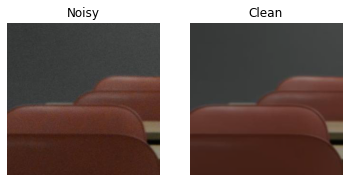

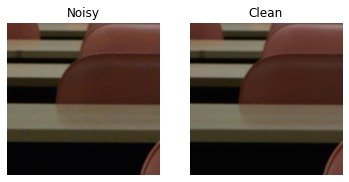

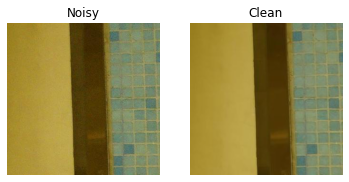

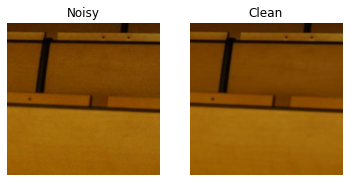

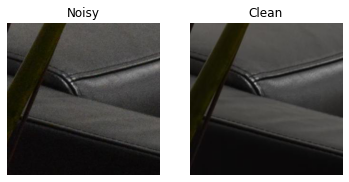

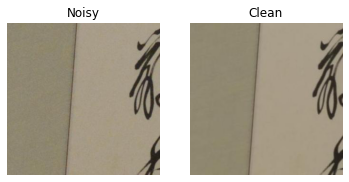

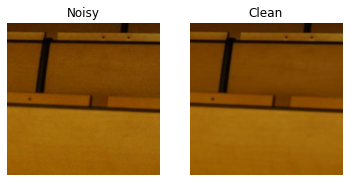

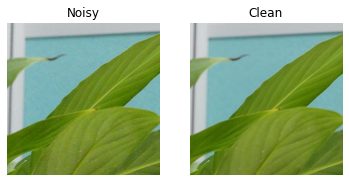

In [5]:
# 展示加噪之后的图像和原图像
x = test_set[2]

fig, axes = plt.subplots(ncols=2)
myimshow(x[0], ax=axes[0])
axes[0].set_title('Noisy')
myimshow(x[1], ax=axes[1])
axes[1].set_title('Clean')
print(f'image size is {x[1].shape}.')
x = test_set[3]

fig, axes = plt.subplots(ncols=2)
myimshow(x[0], ax=axes[0])
axes[0].set_title('Noisy')
myimshow(x[1], ax=axes[1])
axes[1].set_title('Clean')
print(f'image size is {x[1].shape}.')
x = test_set[18]

fig, axes = plt.subplots(ncols=2)
myimshow(x[0], ax=axes[0])
axes[0].set_title('Noisy')
myimshow(x[1], ax=axes[1])
axes[1].set_title('Clean')
print(f'image size is {x[1].shape}.')

x = test_set[9]

fig, axes = plt.subplots(ncols=2)
myimshow(x[0], ax=axes[0])
axes[0].set_title('Noisy')
myimshow(x[1], ax=axes[1])
axes[1].set_title('Clean')
print(f'image size is {x[1].shape}.')

x = test_set[1]

fig, axes = plt.subplots(ncols=2)
myimshow(x[0], ax=axes[0])
axes[0].set_title('Noisy')
myimshow(x[1], ax=axes[1])
axes[1].set_title('Clean')
print(f'image size is {x[1].shape}.')

x = test_set[7]

fig, axes = plt.subplots(ncols=2)
myimshow(x[0], ax=axes[0])
axes[0].set_title('Noisy')
myimshow(x[1], ax=axes[1])
axes[1].set_title('Clean')
print(f'image size is {x[1].shape}.')

x = test_set[9]

fig, axes = plt.subplots(ncols=2)
myimshow(x[0], ax=axes[0])
axes[0].set_title('Noisy')
myimshow(x[1], ax=axes[1])
axes[1].set_title('Clean')
print(f'image size is {x[1].shape}.')

x = test_set[14]

fig, axes = plt.subplots(ncols=2)
myimshow(x[0], ax=axes[0])
axes[0].set_title('Noisy')
myimshow(x[1], ax=axes[1])
axes[1].set_title('Clean')
print(f'image size is {x[1].shape}.')

In [6]:
def psnr1(img1, img2):
    mse = np.mean((img1 - img2) ** 2 )
    if mse < 1.0e-10:
        return 100
    return 10 * math.log10(255.0**2/mse)

In [7]:
# 模型
class DUDnCNN(nn.Module):
    def __init__(self, D, C=64):
        super(DUDnCNN, self).__init__()
        self.D = D
        k = [0]
        k.extend([i for i in range(D//2)])
        k.extend([k[-1] for _ in range(D//2, D+1)])
        l = [0 for _ in range(D//2+1)]
        l.extend([i for i in range(D+1-(D//2+1))])
        l.append(l[-1])
        holes = [2**(kl[0]-kl[1])-1 for kl in zip(k,l)]
        dilations = [i+1 for i in holes]
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=dilations[0], dilation=dilations[0]))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=dilations[i+1], dilation=dilations[i+1]) for i in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=dilations[-1], dilation=dilations[-1]))

        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='leaky_relu')
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
#         self.se = nn.Sequential(
#             nn.AdaptiveAvgPool2d((1,1)),
#             nn.Conv2d(3,3,kernel_size=1),
#             nn.ReLU(),
#             nn.Conv2d(3,3,kernel_size=1),
#             nn.Sigmoid()
#         )
        self.c = nn.Sequential(
            nn.Conv2d(C,3,kernel_size=3,padding=1)    
        )
        self.d = nn.Sequential(
            nn.Conv2d(6,3,kernel_size=1)    
        )
        self.Tanh= nn.Tanh()
        
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))
    def forward(self, x):
        D = self.D
        h = F.leaky_relu(self.conv[0](x))
        h_buff = []
        for i in range(D//2 - 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            h_buff.append(h)
        for i in range(D//2 - 1, D//2 + 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
        for i in range(D//2 + 1, D):
            j = i - (D//2 + 1) + 1
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1]((h + h_buff[-j]) / np.sqrt(2))
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h)) 


#         x1 = self.c(h)
#         out = torch.cat([x,x1],1)
#         out= self.Tanh(out)
#         out = self.d(out)
#         out = out*x1

        
        y = self.conv[D+1](h) + x


#         y = out+x
        
        return y

In [8]:
# 训练
lr = 0.001
batch_size = 1
loss = nn.MSELoss()
net = DUDnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
num_epochs = 50
a = []
b = []
c = []
d = []

In [9]:
def train(net, train_iter, test_iter, num_epochs, lr, batch_size, loss, adam, device):
    train_iter = td.DataLoader(train_iter, batch_size=batch_size, shuffle=True,
                                     drop_last=True, pin_memory=True)
    test_iter = td.DataLoader(test_iter, batch_size=batch_size, shuffle=False,
                                   drop_last=True, pin_memory=True)
    
    
    loss1=0
    num1=0
    psnr1=0
    
    
    loss2=0
    num2=0
    psnr2=0
    
    for epoch in range(num_epochs):
        s = time.time()
        net.train()
        for x, d1 in train_iter:
            adam.zero_grad()
            x, d1 = x.to(device), d1.to(device)
            y = net(x)
            l = loss(y,d1)
            l.backward()
            adam.step()
            with torch.no_grad():
                loss1 += l.item()
                num1 += 1
                n = x.shape[0] * x.shape[1] * x.shape[2] * x.shape[3]
                psnr1 += 10*torch.log10(4*n/(torch.norm(y-d1)**2))
        ss = time.time()
        
        for a1, b1 in test_iter: 
            with torch.no_grad():
                a1, b1 = a1.to(device), b1.to(device)
                c1 = net(a1)
                ll = loss(c1,b1)
                n = a1.shape[0] * a1.shape[1] * a1.shape[2] * a1.shape[3]
                loss2 += ll.item()
                num2 += 1
                psnr2 += 10*torch.log10(4*n/(torch.norm(c1-b1)**2))
            
        l1 = loss1/num1
        p1 = psnr1/num1
        p1 = p1.item()
        a.append(p1)
        c.append(l1)
        
        l2 = loss2/num2
        p2 = psnr2/num2
        p2 = p2.item()
        b.append(p2)
        d.append(l2)
        
        loss1=0
        num1=0
        psnr1=0
        
        loss2=0
        num2=0
        psnr2=0
            
        print("Epoch {} (Time: {:.2f}s)".format(
                epoch, ss - s),f'Train loss {l1:.3f}, Test loss {l2:.3f},train psnr {p1:.3f}, '
          f'test psnr {p2:.3f}')
#         print(f'loss {l:.3f}, loss1 {l:.3f},train psnr {running_psnr:.3f}, '
#           f'test psnr {running_psnr1:.3f}')
    return a,b,c,d

In [10]:
a,b,c,d = train(net, train_set, test_set, num_epochs, lr, batch_size, loss, adam, device)

KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(9, 7))

noisy = test_set[13][0]
pic = test_set[13][1]

noisy1 = test_set[5][0]
pic1 = test_set[5][1]

noisy2 = test_set[19][0]
pic2 = test_set[19][1]


myimshow(noisy, ax=axes[0][1])
axes[0][1].set_title('Noisy image')  

myimshow(noisy1, ax=axes[1][1])


myimshow(noisy2, ax=axes[2][1])



 

#with torch.no_grad():
#        denoised = net(noisy.to(device))
with torch.no_grad():
        denoised = net(noisy[None].to(device))[0]
        denoised1 = net(noisy1[None].to(device))[0]
        denoised2 = net(noisy2[None].to(device))[0]

myimshow(denoised, ax=axes[0][2])
axes[0][2].set_title('Denoised image')
myimshow(pic, ax=axes[0][0])
axes[0][0].set_title('Clean image')

myimshow(denoised1, ax=axes[1][2])
myimshow(pic1, ax=axes[1][0])


myimshow(denoised2, ax=axes[2][2])
myimshow(pic2, ax=axes[2][0])




In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(9, 4))
axes[0].clear()
axes[1].clear()

a = np.array(a)
b = np.array(b)
c = np.array(c)
d = np.array(d)

axes[1].plot(a, label='train psnr')
axes[1].plot(b, label='test psnr')
axes[1].set_ylabel('psnr')
axes[1].set_xlabel('Epoch')
axes[1].legend()

axes[0].plot(c, label='train loss')
axes[0].plot(d, label='test loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('Epoch')
axes[0].legend()